In [20]:
%%time
num_class = 20 #first n most numerous classes
rType = 'mixed' # fingerprint/descriptor/mixed

mol_matrix = []
for line in receptors[:num_class]:
    name = line[0]
    mol_list = read_ism(path + name)
    mol_matrix.append(mol_list)
mol_matrix[0][:3]

train_set,val_mols,val_labels = prepare_sets(mol_matrix, 0.2, rType)

CPU times: user 2min 52s, sys: 334 ms, total: 2min 52s
Wall time: 2min 51s


In [46]:
layers = [500,500]
learning_rate = 0.001
batch_size = 15
epochs = 10

In [47]:
tf.reset_default_graph()
tf.set_random_seed(15)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
start = time.time()
# Automatic network variables
isize = len(val_mols[0])
osize = num_class
active_layers = setup_layers(layers, osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets
saver = tf.train.Saver(max_to_keep=12)
# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
# Prediction
predict = tf.round(tf.nn.sigmoid(a))
# Train the network
tr_rate, val_rate, f1 = train_network(train_set, batch_size, epochs)
full_time = timer(start,time.time())
"--END--"

2017-05-24 14:07:18
38852  iterations
  0%, 00:00:00
 10%, 00:00:11
 20%, 00:00:21
 30%, 00:00:32
 40%, 00:00:42
 50%, 00:00:53
 60%, 00:01:03
 70%, 00:01:13
 80%, 00:01:24
 90%, 00:01:34
100%, 00:01:45


'--END--'

### Plot prediction accuracy

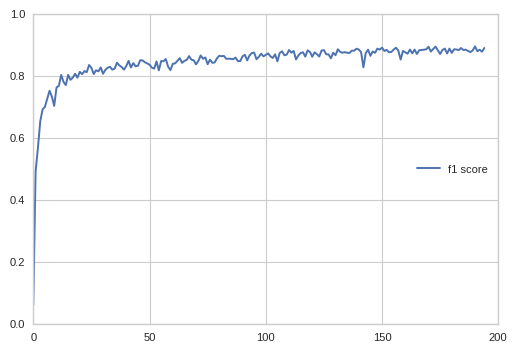

In [49]:
plt.plot(f1, label='f1 score')
plt.ylim([0,1])
plt.legend(loc=5);

Classes: 20, val_rate: 0.718, Layers: [500, 500], rType: mixed
lr_rate: 0.001, batch_size: 15, epochs: 10, time: 00:01:45


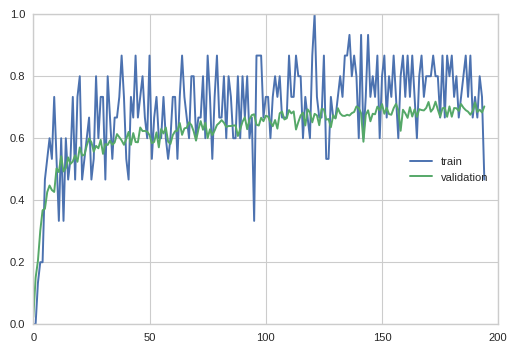

In [48]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.ylim([0,1])
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {:2}, val_rate: {:.4}, Layers: {}, rType: {}\nlr_rate: {}, batch_size: {}, epochs: {}, time: {}".format(
        osize, max(val_rate), layers, rType, learning_rate, batch_size, epochs, full_time))

Classes: 20, val_rate: 0.718, Layers: [500, 500], rType: mixed
lr_rate: 0.001, batch_size: 15, epochs: 10, time: 00:01:45


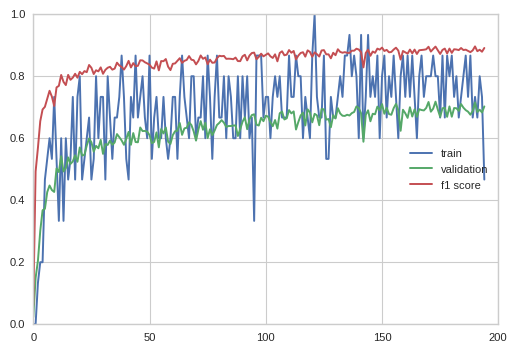

In [50]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.plot(f1, label='f1 score')
plt.ylim([0,1])
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {:2}, val_rate: {:.4}, Layers: {}, rType: {}\nlr_rate: {}, batch_size: {}, epochs: {}, time: {}".format(
        osize, max(val_rate), layers, rType, learning_rate, batch_size, epochs, full_time))

---

# Imports

In [1]:
#Imports - general
import random
random.seed(15)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from math import ceil, sqrt
import sklearn
from sklearn.metrics import f1_score
%matplotlib inline

#Imports - RDKit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import *

#Imports - additional
from os import listdir #for getting a list of files in a dir to process checkpoints
import time # for real-time timing the progress of the network

path = 'data/targets/'   #path to .ism files
batch_number = 0
#Get the list of filenames in data/targets/
#ordered by the size of class, descending:
with open("receptors_desc.txt", "r") as f:
    receptors = [l.strip().split() for l in f.readlines()]
#receptors[:5]

#---

# Functions

## Preparing the dataset

def read_ism(file_name):
    ''' Parse an .ism file, returning a list of smiles of molecules '''
    mol_matrix = []
    with open(file_name, 'r') as f:
        frl = f.readlines()
    for line in frl:
        line = line.split('\t')
        smile = line[0]
        mol_matrix.append(smile)
    return mol_matrix

#### Creating molecule representations

def get_class_vectors(mol_matrix, rType = 'fingerprint'):
    ''' For each molecule in the array (list of lists):
        create a binary vector showing which classes it belongs to
        and its representation for training (fingerprint or descriptor)
    '''
    cv_dict = {}
    for i,l in enumerate(mol_matrix):
        for smile in l:
            if smile not in cv_dict:
                
                mol = MolFromSmiles(smile)
                if rType == 'fingerprint':
                    rep = fingerprint(mol)
                elif rType == 'descriptor':
                    rep = descriptor(mol)
                else:
                    rep = list(fingerprint(mol)) + descriptor(mol)
                
                labels = [0]*len(mol_matrix)
                cv_dict[smile] = [rep, labels]
            cv_dict[smile][1][i] = 1
    return cv_dict

def fingerprint(mol):
    return GetMorganFingerprintAsBitVect(mol,2,1024)

def descriptor(mol):
    functions = [CalcChi0n,
            CalcChi0v,
            CalcChi1n,
            CalcChi1v,
            CalcChi2n,
            CalcChi2v,
            CalcChi3n,
            CalcChi3v,
            CalcChi4n,
            CalcChi4v,
            CalcExactMolWt,
            CalcFractionCSP3,
            CalcHallKierAlpha,
            CalcKappa1,
            CalcKappa2,
            CalcKappa3,
            CalcLabuteASA,
            CalcNumAliphaticCarbocycles,
            CalcNumAliphaticHeterocycles,
            CalcNumAliphaticRings,
            CalcNumAmideBonds,
            CalcNumAromaticCarbocycles,
            CalcNumAromaticHeterocycles,
            CalcNumAromaticRings,
            CalcNumBridgeheadAtoms,
            CalcNumHBA,
            CalcNumHBD,
            CalcNumHeteroatoms,
            CalcNumHeterocycles,
            CalcNumLipinskiHBA,
            CalcNumLipinskiHBD,
            CalcNumRings,
            CalcNumSaturatedCarbocycles,
            CalcNumSaturatedHeterocycles,
            CalcNumSaturatedRings,
            CalcNumSpiroAtoms,
            CalcTPSA]
        
    descriptors = []
    for function in functions:
        descriptors.append(function(mol))
    return descriptors

def prepare_sets(mol_matrix, val_prc=0.25, rType='fingerprint'):
    ''' Create training and validation sets with labels from an array of smiles, shuffling the data '''
    # mol_matrix = "list of lists of molecules"
    # mol_list = "list of molecules" <- how about class_i ?
    class_count = len(mol_matrix)
    lengths = [len(mol_list) for mol_list in mol_matrix]
    starts = [int(l*val_prc) for l in lengths] #start of training sets, end of validation sets
    
    # Create a representation and a class vector for each molecule
    molecules = get_class_vectors(mol_matrix,rType)
    
    # Create the validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols, val_labels = [],[]
    
    # shuffle molecules in each class so that selection for validation is random
    for mol_list in mol_matrix:
        random.shuffle(mol_list)
    
    for i in range(class_count):
        for j in range(starts[i]):
            mol = mol_matrix[i][j]
            val_mols.append(molecules[mol][0])
            val_labels.append(molecules[mol][1])
    # Conversion to numpy array for tensorflow training
    val_mols = np.array(val_mols)
    val_labels = np.array(val_labels)
    
    # Shuffle the remaining data and create the training set
    molecules_training = []
    for i,l in enumerate(mol_matrix):
        molecules_training += l[starts[i]:]
    
    random.shuffle(molecules_training)
    train_set = [[],[]]
    
    for mol in molecules_training:
        train_set[0].append(molecules[mol][0])
        train_set[1].append(molecules[mol][1])
    # Conversion to numpy array for tensorflow training
    train_set[0] = np.array(train_set[0])
    train_set[1] = np.array(train_set[1])
    
    return train_set, val_mols, val_labels

## Neuron layers

def neuron_layer(isize, hsize, prev_layer):
    ''' Create a single neuron layer - weight, bias, placeholder '''
    # weights and biases
    w = tf.Variable(tf.random_normal((isize, hsize), stddev=1/sqrt(isize)))
    b = tf.Variable(tf.random_normal((hsize,), stddev=0.1))
    # neuron
    h = tf.nn.relu(tf.matmul(prev_layer, w) + b)
    return w,b,h

def setup_layers(layers, osize, isize=1024):
    ''' Create placeholders, weights and biases for all requested layers '''
    x = tf.placeholder(tf.float32, shape=[None,isize])
    active_layers = {'x':x,'w':[],'b':[],'h':[]}
    
    for i in range(len(layers)):
        if i == 0:
            w,b,h = neuron_layer(isize, layers[i], x)
        else:
            w,b,h = neuron_layer(layers[i-1], layers[i], prev_h)
        active_layers['w'].append(w)
        active_layers['b'].append(b)
        active_layers['h'].append(h)
        prev_h = h
    
    # Output Layer
    wo = tf.Variable(tf.random_normal((layers[-1], osize), stddev=1/sqrt(layers[-1])))
    bo = tf.Variable(tf.random_normal((osize,), stddev=0.1))
    a = tf.matmul(h, wo) + bo #h is the one last initialized in the loop > of the last layer
    
    # Placeholder for targets
    t = tf.placeholder(tf.float32, shape=[None, osize])
    
    active_layers['out'] = [wo,bo,a,t]
    return active_layers

## Training functions

def next_batch(data, size): #data = [[fingerprints], [labels]]
    ''' Extract the next batch from a dataset '''
    global batch_number
    batch_number = batch_number%((len(data[0]))//size)
    start = batch_number*size
    batch_number += 1
    return data[0][start:start+size], data[1][start:start+size]

def timer(start,end):
    ''' For timing the training of the network '''
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds))

def train_network(data, batch_size, epochs):
    ''' This function trains the network, returning the rate of training and validation accuracy '''
    # Variables:
    global start
    iterations = ceil(len(data[1]) * epochs / batch_size)
    print(iterations, ' iterations')
    tr_rate = []
    val_rate = []
    f1 = []
    batch_number = 0
    save_step=0
    # Training:
    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        saver.save(session, "tmp/checkpoint", global_step=save_step)
        
        # Train the network
        for i in range(iterations):
            fps, labels = next_batch(data, batch_size)
            session.run(train, feed_dict={x: fps, t: labels})
            
            # Show progress and make a checkpoint
            if i == 0 or (i+1)%(iterations//10) == 0:
                progress = int((i+1)/(iterations//10))*10
                now = timer(start,time.time())
                print("%3i" % progress + '%, ' + str(now))
                save_step += 1
                saver.save(session, "tmp/checkpoint", global_step = save_step)
            
            # Check predictions
            if i % 200 == 0:
                
                tr_target = labels
                tr_predictions = session.run(predict, feed_dict={x: fps, t: labels})
                tr_rate.append((tr_target == tr_predictions).all(axis=1).mean())

                val_predictions = session.run(predict, feed_dict={x: val_mols, t: val_labels})
                val_rate.append((val_labels == val_predictions).all(axis=1).mean())
                
                f1.append(f1_score(val_labels, val_predictions, average='micro'))
        # Final checkpoint
        saver.save(session, "tmp/checkpoint", global_step=save_step+1)
    return tr_rate, val_rate, f1

---